# Analysis of APT data (statistical distributions)

**System**
* Alloy stoichiometry (ideal): $Al_{0.1}FeNiCrCo$
* Lattice: FCC
* Lattice constant: 3.57A

**APT measurement**
* Detector efficiency: 33%
* position uncertainty (standard deviation): 5A (in x-, y-directions) and 3A in z-direction

## Setup

In [1]:
# Notebook settings

# code development settings (automatically reload modified modules)
%load_ext autoreload
%autoreload 2

# plotting backend
%matplotlib inline

In [2]:
# basic libraries

import os, sys
import re
import copy
import glob
from itertools import product
import pickle
from collections import Counter
import numpy as np
#import scipy.io
from scipy.stats import multinomial, binom, chi2
from scipy.optimize import fmin
from sklearn.neighbors import NearestNeighbors

# plotting
import matplotlib.pyplot as plt

# data handling
# import pyUSID as usid
# import h5py
# import pandas as pd
# import xarray as xr

# parallelization
# from subprocess import Popen, PIPE
import multiprocessing as mp

In [3]:
# local library
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_mc, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt, cfg_replicate
from statmechlib.forcefields import sd2

In [4]:
# project directories
data_raw = '../data/interim'
src_dir = '../src/utils'
sim_dir = '../sim/enth_model'

In [5]:
sys.path.append(src_dir)
from utils import *

## Spatial statistics - XY profiles

In [6]:
data_id = ['0', '1', '2', '3', '4', 'Total', 'Noise']

data = {}
for dat in data_id:
    data[dat] = np.loadtxt(os.path.join(data_raw, f'RamaTest_CleanXYDist{dat}'))

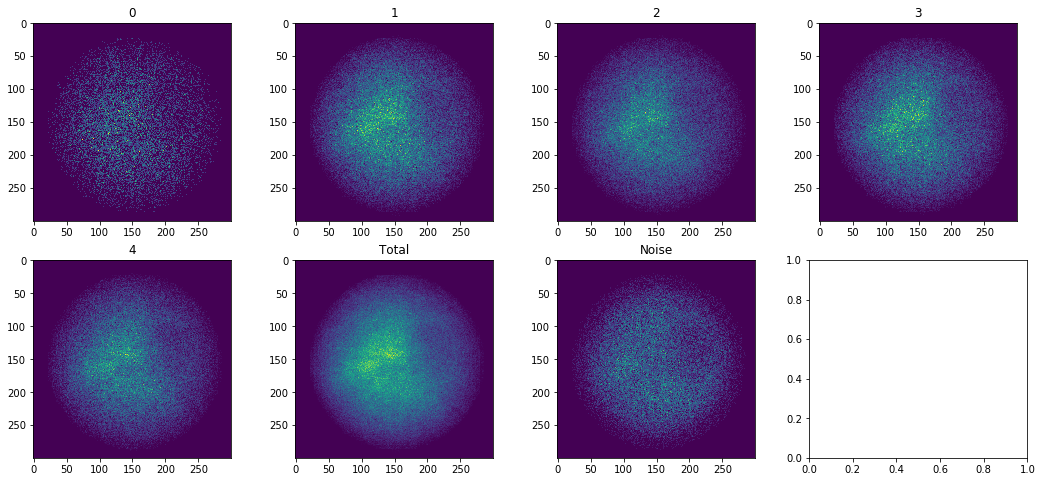

In [64]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axs = axs.ravel()
for i, dat in enumerate(data_id):
    axs[i].imshow(data[dat])#[120:180, 120:180])
    axs[i].set_title(dat)

**Calculate density distributions**

In [8]:
# average over regions of 10x10 (coarse-graining)
data_big = data[data_id[-2]]
new_shape = np.int_(np.array(data_big.shape))//5
print(new_shape, data_big.shape)

data_small = np.zeros(new_shape, dtype=int)
for i, j in product(range(new_shape[0]), range(new_shape[1])):
    data_small[i, j] = np.mean(data_big[5*i:5*(i+1), 5*j:5*(j+1)])
    #print(i, j, 5*j, 5*(j+1))
        
data_small.shape

[60 60] (300, 300)


(60, 60)

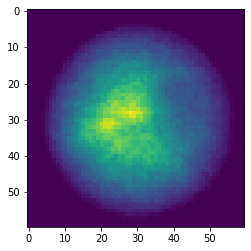

In [9]:
# coarse grained distribution
plt.imshow(data_small)

30.83684176850726


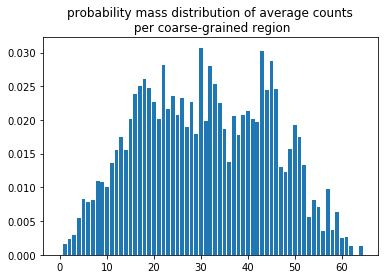

In [218]:
# calculate inverse cummulative distribution of detection rates for sampling during the noise addition

data_count = data_small.flatten()
bin_cnt = np.bincount(np.int_(data_count))
dens_cnt = np.array([i*v for i, v in enumerate(bin_cnt)])

# print(dens_cnt)
# print(np.cumsum(dens_cnt))

#plt.bar(list(range(len(dens_cnt))), dens_cnt, alpha=0.2, label=dat)
x = np.array(list(range(len(dens_cnt))))
dns = dens_cnt/np.sum(dens_cnt)
plt.bar(list(range(len(dns))), dns, alpha=1.0, label=dat)
plt.title('probability mass distribution of average counts\n per coarse-grained region')
dns_cumsum = np.cumsum(dns)
mean = np.sum(x*dns)

print(mean)
# print(len(dns))
# print(x/mean)
# print(x/mean*0.33)
# print(dns_cumsum)
detected = x/mean*0.33
n_bins = 10000
dist_inv = np.empty(n_bins, dtype=int)

#print(dns_cumsum)          

for k in range(n_bins):
    di = k/float(n_bins)
    for jj, dd in enumerate(dns_cumsum):
        #print('d', k, di, jj, dd)
        if di >= dd:
            pass
        else:
            jmax = jj
            break

    dist_inv[k] = jj

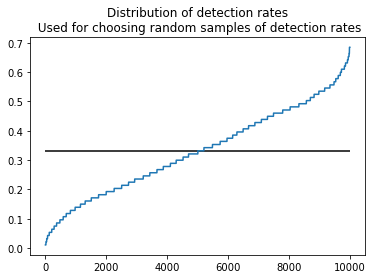

In [217]:
plt.plot(detected[dist_inv])
plt.title('Distribution of detection rates\n Used for choosing random samples of detection rates')
plt.hlines(0.33,0,10000)

## Read KNN statistics

In [65]:
# compositions, concentrations, atom types
element = ['Al','Fe','Ni','Cr','Co']
ntype = len(element)

# numbers of KNNs of a particular atom i of type ti
knn = list(range(1,13))
#knn += [20, 40, 100, 200, 500, 1000]

In [66]:
# functions to read data files with pairwise statistics

def read_pairwise(file_name, nn, ntype):
    """
    Parameters
    ----------
    file_name: str
        Input file with pairwise statistics
    nn: int
        number of nearest neighbors
    ntype: number of atom types
    
    Returns
    -------
    stats: ndarray(ntype, ntype, nn)
        all pairwise statistics for all atom types
    """
    
    # output array
    stats = np.zeros((ntype, ntype, nn+1), dtype=int)
    
    # regex to extract particle types
    atom_info = re.compile(r'IonType\s*(\d+)\s*,\s*type\s*(\d+)\s+')
    
    with open(file_name, 'r') as fin:
        for line in iter(fin.readline, ''):
            m = atom_info.search(line)
            i, j = [int(c) for c in m.groups()]

            counts = re.findall('\d+', fin.readline())
            stats[i, j, :] = [int(c) for c in counts]

    return stats

In [67]:
targets = {}
for k in knn:
    targets[k] = read_pairwise(os.path.join(data_raw, f'RamaTest_Clean_PatternK{k}_PairWise'), k, ntype)

In [68]:
targets[12].shape

(5, 5, 13)

In [69]:
# count statistics and concentrations
counts = np.sum(targets[knn[5]], axis=2)[:,0]
assert np.array_equal(counts, np.sum(targets[knn[0]], axis=2)[:,0])

conc = counts/np.sum(counts)

tot_counts = np.sum(counts)

In [70]:
tot_counts, counts, conc

(1200233,
 array([ 30699, 300950, 300909, 280969, 286706]),
 array([0.02557753, 0.25074298, 0.25070882, 0.23409538, 0.23887529]))

In [71]:
# same counts from 2D profiles
[int(np.sum(data[dat])) for dat in data_id]

[30699, 300950, 300909, 280969, 286706, 1200233, 120556]

## Generate random distributions (null hypothesis)

* Assume that there are no interactioins between particles and for each KNN generate multinomial distributions with parameters (probabilities) set to mole fractions.

In [72]:
def get_binomials(k, probs):

    probs_null = np.zeros((ntype, ntype, k+1), dtype=float)

    # marginal distributions for selected atoms (equivalent to binomial distributions)
    for it in range(ntype):
        for jt in range(ntype):
            bn = binom(n=k, p=probs[jt])
            pmf_bn = probs[it]*bn.pmf(range(k+1))
            probs_null[it, jt, :] = pmf_bn
            #print(k, it, jt, pmf_bn)

    return probs_null

In [184]:
null_reference = {}
null_counts = {}
for k in knn:
    null_reference[k] = get_binomials(k, conc)
    null_counts[k] = null_reference[k]*tot_counts*1134153.0/300950

## Convolute simulation data

In [74]:
def latt_to_real_coords(trj, scale=1.0):

    """
    Read xyz file with lattice coordinates
    and return rescaled atomic configurations in real units and (orthogonal) box dimensions.
    """
    
    boxs = []
    xyzs = []
    for box, xyz in zip(trj['box_latt'], trj['xyz_latt']):
        boxs.append(box*scale)
        xyzs.append(xyz*scale)
        # scale to fractional coordinates
        xyzs[-1] /= np.diag(boxs[-1])
    trj['box'] = boxs
    trj['xyz'] = xyzs
    return trj

In [93]:
def add_experimental_noise(trj, detect_rate=0.0, disp=[0.0, 0.0, 0.0], unknown_frac=0.0):
    """
    Apply random noise emulating APT experiment.
    Includes detector efficiency (only 33% retained) and random displacement.
    
    Parameters
    ----------
    xyz_in: list of ndarrays
        list of atom coordinates
    box: ndarray (3x3)
        box dimensions
    loss_rate: float or list of floats
        loss rate, overall (float) or per atom type (list)
    disp: array-like, shape(3)
        random displacement of atoms in x, y, z directions
        standard deviation of a Gaussian distribution
        
    Returns
    -------
    config_out: ndarray
        list of atoms and their coordinates in xyz format (type, x)
    """    
    
    xyzs = trj['xyz']
    boxs = trj['box']
    typs = trj['atom_type']

    xyzs_mod = []
    typs_mod = []

    for xyz, box, typ in zip(xyzs, boxs, typs):
        
        boxv = np.diag(box)

        xyz_mod = []
        typ_mod = []
        
        # select detection rate for the present box
        if isinstance(detect_rate, float):
            d_rate = detect_rate
        else:
            detected, dist_inv = detect_rate
            d_rate = detected[np.random.choice(dist_inv)]
    
        #print(d_rate)

        for r, t in zip(xyz, typ):
        
            # Step 1: remove a given fraction of particles
            if np.random.random() > d_rate:
                continue
            
            # Step 2: displace atoms using Gaussian noise
            rr = boxv*r
            rr += np.array([np.random.normal(loc=0.0, scale=disp[i]) for i in range(3)])

            # adjust positions using periodic boundary conditions
            rr = np.where(rr < 0.0, rr+boxv, rr)
            rr = np.where(rr > boxv, rr-boxv, rr)
            
            rr /= boxv
                
            xyz_mod.append(rr)
            
            # unknown type (type==6)
            if np.random.random() < unknown_frac:
                typ_mod.append(6)
            else:
                typ_mod.append(t)

                
        xyzs_mod.append(np.array(xyz_mod))
        typs_mod.append(np.array(typ_mod))


    return xyzs_mod, typs_mod

In [94]:
def real_coords(xyzs, boxs):
    xyzs_mod = []
    for xyz, box in zip(xyzs, boxs):
        boxv = np.diag(box)
        xyzs_mod.append(xyz*boxv)

    return xyzs_mod

In [95]:
def select_core(xyzs, boxs, tis):
    """
    Selects the central (core) region of a configuration with all coordinates
    closer to the center than surface.
    """
    
    xyzs_core = []    
    tis_core = []
    for xyz, box, ti in zip(xyzs, boxs, tis):

        bv = np.diag(box)
    
        r_core = []
        t_core = []
        for r, t in zip(xyz, ti):
            if r[0]<0.25*bv[0] or r[1]<0.25*bv[1] or r[2]<0.25*bv[2]:
                continue
            if r[0]>=0.75*bv[0] or r[1]>=0.75*bv[1] or r[2]>=0.75*bv[2]:
                continue

            r_core.append(r)
            t_core.append(t)
            
        xyzs_core.append(np.array(r_core))
        tis_core.append(np.array(t_core))

    return xyzs_core, tis_core

In [430]:
# read in a set of trajectories
#trj_dirs = ['txinf', 'tx500', 'tx700', 'tx1000']
#trj_dirs = ['txinf']
trj_dirs = ['6x700']

#trj_dirs = ['3x700']
sim_dir_m1 = '../sim/m1'
sim_dir_m2 = '../sim/m2'
sim_dir_m3 = '../sim/m3'
sim_dir_m4 = '../sim/m4'
sim_dir_m5 = '../sim/m5'
sim_dir_m6 = '../sim/m6'

In [431]:
#trjs = {}
for key in trj_dirs:
    # read trajectory info
    trjs[key] = read_lattice_mc(os.path.join(sim_dir_m6, key), verbose=1)

Reading ../sim/m6/6x700/lg.hst
Reading ../sim/m6/6x700/lg.run
Reading ../sim/m6/6x700/lg.xyz
Reading ../sim/m6/6x700/lg.mld


## Add experimental noise

In [432]:
unknown_frac = counts[-1]/np.sum(counts)

# analyze configurations
for key, trj in trjs.items():
    if key not in ['6x700']:
        continue
    print('trj:', key)

    # convert from lattice to real coordinates
    trj = latt_to_real_coords(trj, 3.57/2.0)

    # model of experimental noise
    xyzs, typs = add_experimental_noise(trj, detect_rate=(detected, dist_inv), disp=np.array([5.0, 5.0, 3.0]), unknown_frac=0.0)
    #xyzs, typs = add_experimental_noise(trj, loss_rate=0.0, disp=np.array([0.0, 0.0, 0.0]), unknown_frac=unknown_frac)
    trjs[key]['xyz_noise'] = xyzs
    trjs[key]['atom_type_noise'] = typs

trj: 6x700


In [433]:
#[(k, v[0:5]) for k, v in trjs['tx700'].items()]

In [434]:
# 1. replicate configurations to avoid dealing with periodic boundary conditions
# 2. convert to real coordinates
# 3. select core
for key, trj in trjs.items():
    if key not in ['6x700']:
        continue

    print('trj:', key)
    xyzs = []
    boxs = []
    tis = []
    for xyz, box, ti in zip(trj['xyz_noise'], trj['box'], trj['atom_type_noise']):
        xyz_big, box_big = cfg_replicate(xyz, box, vec_a=2, vec_b=2, vec_c=2)
        xyzs.append(xyz_big)
        boxs.append(box_big)
        tis.append(np.tile(ti, 2*2*2))                                          

    trj['xyz_noise'] = xyzs
    trj['box_noise'] = boxs
    trj['atom_type_noise'] = tis
    
    trj['xyz_noise'] = real_coords(trj['xyz_noise'], trj['box_noise'])
    
    trj['xyz_core'], trj['atom_type_core'] = select_core(trj['xyz_noise'], trj['box_noise'], trj['atom_type_noise'])

trj: 6x700


In [435]:
# with open('../data/interim/trjs.pickle', 'wb') as fo:
#     pickle.dump(trjs, fo)

### Neighbor statistics

In [436]:
knns = list(range(1,13))
#knns += [20, 40, 100, 200]

# 3. create nighbor model with the maximum of nearest neighbors (1000). KDTree should make this Nlog(N)
neigh = NearestNeighbors(n_neighbors=knns[-1], algorithm='kd_tree', n_jobs=-1)

In [437]:
def get_knn_stats(indices, ti_core, ti, knns=[], ntype=2):
    """
    Returns
    -------
        Atom-atom statistics for a given configuration
    """
    
    #ntype = max(list(Counter(ti).keys()) + list(Counter(ti_core).keys()))

    k_stats = []
    for k in knns:
        hst = np.zeros((ntype, ntype, k+1), dtype=int)
        
        for i, ind in enumerate(indices):
            nbr_dict = Counter(ti[ind[1:k+1]])
            for t in range(1, ntype+1):
                c = nbr_dict.get(t, 0)
                hst[ti_core[i]-1, t-1, c] += 1
            
        k_stats.append(hst)
            
    return k_stats

In [438]:
for key, trj in trjs.items():
    if key not in ['6x700']:
        continue

    print('trj:', key)

    knn_stats = []
    for it, (cor, xyz, ti_core, ti) in enumerate(zip(trj['xyz_core'], trj['xyz_noise'], trj['atom_type_core'], trj['atom_type_noise'])):
        print(it, len(ti_core), len(ti))
        if it < 2000:
            continue
        neigh.fit(xyz)
        dist, ind = neigh.kneighbors(cor, n_neighbors=knns[-1]+1)
        assert np.array_equal(dist[:,0], np.zeros(dist.shape[0])), "First neighbor is not center"
        knn_stats.append(get_knn_stats(ind, ti_core, ti, knns=knns, ntype=ntype))

    trj['knn'] = knn_stats

trj: 6x700
0 577 4616
1 689 5512
2 481 3848
3 154 1232
4 559 4472
5 260 2080
6 309 2472
7 593 4744
8 513 4104
9 460 3680
10 383 3064
11 301 2408
12 630 5040
13 334 2672
14 512 4096
15 407 3256
16 103 824
17 699 5592
18 110 880
19 467 3736
20 371 2968
21 342 2736
22 748 5984
23 320 2560
24 534 4272
25 601 4808
26 633 5064
27 431 3448
28 277 2216
29 566 4528
30 263 2104
31 454 3632
32 530 4240
33 656 5248
34 612 4896
35 17 136
36 156 1248
37 250 2000
38 685 5480
39 650 5200
40 584 4672
41 839 6712
42 345 2760
43 247 1976
44 696 5568
45 238 1904
46 324 2592
47 383 3064
48 673 5384
49 281 2248
50 668 5344
51 458 3664
52 822 6576
53 653 5224
54 414 3312
55 363 2904
56 504 4032
57 488 3904
58 396 3168
59 440 3520
60 792 6336
61 122 976
62 679 5432
63 640 5120
64 688 5504
65 580 4640
66 615 4920
67 453 3624
68 206 1648
69 735 5880
70 777 6216
71 731 5848
72 357 2856
73 69 552
74 169 1352
75 446 3568
76 187 1496
77 568 4544
78 841 6728
79 450 3600
80 888 7104
81 230 1840
82 403 3224
83 500 400

1167 231 1848
1168 323 2584
1169 461 3688
1170 96 768
1171 304 2432
1172 672 5376
1173 322 2576
1174 571 4568
1175 317 2536
1176 674 5392
1177 129 1032
1178 763 6104
1179 412 3296
1180 170 1360
1181 410 3280
1182 600 4800
1183 622 4976
1184 425 3400
1185 581 4648
1186 311 2488
1187 241 1928
1188 556 4448
1189 647 5176
1190 443 3544
1191 604 4832
1192 719 5752
1193 423 3384
1194 438 3504
1195 112 896
1196 237 1896
1197 892 7136
1198 688 5504
1199 705 5640
1200 129 1032
1201 831 6648
1202 171 1368
1203 533 4264
1204 294 2352
1205 246 1968
1206 313 2504
1207 472 3776
1208 584 4672
1209 741 5928
1210 376 3008
1211 435 3480
1212 347 2776
1213 464 3712
1214 452 3616
1215 586 4688
1216 349 2792
1217 366 2928
1218 171 1368
1219 203 1624
1220 640 5120
1221 221 1768
1222 542 4336
1223 328 2624
1224 557 4456
1225 153 1224
1226 774 6192
1227 195 1560
1228 722 5776
1229 168 1344
1230 589 4712
1231 258 2064
1232 398 3184
1233 639 5112
1234 757 6056
1235 627 5016
1236 224 1792
1237 299 2392
1238 232 

1787 479 3832
1788 255 2040
1789 592 4736
1790 477 3816
1791 575 4600
1792 441 3528
1793 263 2104
1794 428 3424
1795 907 7256
1796 333 2664
1797 537 4296
1798 515 4120
1799 225 1800
1800 471 3768
1801 644 5152
1802 721 5768
1803 326 2608
1804 662 5296
1805 417 3336
1806 551 4408
1807 295 2360
1808 690 5520
1809 682 5456
1810 502 4016
1811 506 4048
1812 470 3760
1813 612 4896
1814 487 3896
1815 465 3720
1816 557 4456
1817 632 5056
1818 631 5048
1819 257 2056
1820 536 4288
1821 345 2760
1822 330 2640
1823 145 1160
1824 551 4408
1825 352 2816
1826 419 3352
1827 798 6384
1828 741 5928
1829 452 3616
1830 537 4296
1831 662 5296
1832 620 4960
1833 353 2824
1834 238 1904
1835 504 4032
1836 124 992
1837 15 120
1838 190 1520
1839 722 5776
1840 755 6040
1841 647 5176
1842 401 3208
1843 573 4584
1844 597 4776
1845 348 2784
1846 590 4720
1847 169 1352
1848 632 5056
1849 205 1640
1850 226 1808
1851 592 4736
1852 445 3560
1853 745 5960
1854 208 1664
1855 504 4032
1856 491 3928
1857 690 5520
1858 184 

2376 62 496
2377 767 6136
2378 518 4144
2379 751 6008
2380 440 3520
2381 84 672
2382 132 1056
2383 749 5992
2384 393 3144
2385 763 6104
2386 433 3464
2387 494 3952
2388 583 4664
2389 72 576
2390 878 7024
2391 660 5280
2392 202 1616
2393 531 4248
2394 626 5008
2395 378 3024
2396 335 2680
2397 588 4704
2398 847 6776
2399 643 5144
2400 270 2160
2401 378 3024
2402 648 5184
2403 452 3616
2404 451 3608
2405 366 2928
2406 232 1856
2407 515 4120
2408 606 4848
2409 230 1840
2410 410 3280
2411 724 5792
2412 608 4864
2413 477 3816
2414 269 2152
2415 149 1192
2416 300 2400
2417 263 2104
2418 503 4024
2419 310 2480
2420 797 6376
2421 455 3640
2422 13 104
2423 622 4976
2424 393 3144
2425 465 3720
2426 576 4608
2427 735 5880
2428 777 6216
2429 477 3816
2430 404 3232
2431 369 2952
2432 336 2688
2433 342 2736
2434 354 2832
2435 911 7288
2436 641 5128
2437 437 3496
2438 529 4232
2439 409 3272
2440 695 5560
2441 592 4736
2442 862 6896
2443 559 4472
2444 665 5320
2445 531 4248
2446 510 4080
2447 359 2872


2966 276 2208
2967 68 544
2968 414 3312
2969 384 3072
2970 83 664
2971 553 4424
2972 704 5632
2973 581 4648
2974 757 6056
2975 646 5168
2976 334 2672
2977 430 3440
2978 123 984
2979 556 4448
2980 716 5728
2981 347 2776
2982 418 3344
2983 716 5728
2984 322 2576
2985 189 1512
2986 579 4632
2987 866 6928
2988 304 2432
2989 101 808
2990 848 6784
2991 435 3480
2992 372 2976
2993 513 4104
2994 450 3600
2995 497 3976
2996 330 2640
2997 543 4344
2998 194 1552
2999 398 3184
3000 341 2728
3001 501 4008
3002 566 4528
3003 230 1840
3004 729 5832
3005 492 3936
3006 586 4688
3007 197 1576
3008 704 5632
3009 481 3848
3010 503 4024
3011 669 5352
3012 735 5880
3013 777 6216
3014 248 1984
3015 686 5488
3016 119 952
3017 340 2720
3018 183 1464
3019 341 2728
3020 453 3624
3021 299 2392
3022 421 3368
3023 342 2736
3024 654 5232
3025 332 2656
3026 232 1856
3027 347 2776
3028 348 2784
3029 698 5584
3030 806 6448
3031 821 6568
3032 428 3424
3033 657 5256
3034 564 4512
3035 123 984
3036 604 4832
3037 422 3376


3557 292 2336
3558 310 2480
3559 456 3648
3560 246 1968
3561 270 2160
3562 955 7640
3563 728 5824
3564 649 5192
3565 565 4520
3566 155 1240
3567 519 4152
3568 164 1312
3569 520 4160
3570 319 2552
3571 624 4992
3572 372 2976
3573 630 5040
3574 941 7528
3575 455 3640
3576 77 616
3577 939 7512
3578 735 5880
3579 882 7056
3580 508 4064
3581 638 5104
3582 606 4848
3583 311 2488
3584 485 3880
3585 719 5752
3586 722 5776
3587 368 2944
3588 81 648
3589 618 4944
3590 777 6216
3591 837 6696
3592 303 2424
3593 237 1896
3594 362 2896
3595 655 5240
3596 223 1784
3597 820 6560
3598 638 5104
3599 560 4480
3600 213 1704
3601 310 2480
3602 262 2096
3603 811 6488
3604 613 4904
3605 573 4584
3606 210 1680
3607 46 368
3608 517 4136
3609 757 6056
3610 574 4592
3611 619 4952
3612 258 2064
3613 151 1208
3614 651 5208
3615 611 4888
3616 210 1680
3617 752 6016
3618 563 4504
3619 432 3456
3620 603 4824
3621 312 2496
3622 679 5432
3623 459 3672
3624 651 5208
3625 538 4304
3626 464 3712
3627 698 5584
3628 345 276

4148 512 4096
4149 751 6008
4150 570 4560
4151 534 4272
4152 318 2544
4153 406 3248
4154 599 4792
4155 68 544
4156 560 4480
4157 223 1784
4158 283 2264
4159 191 1528
4160 189 1512
4161 166 1328
4162 740 5920
4163 137 1096
4164 517 4136
4165 478 3824
4166 578 4624
4167 668 5344
4168 757 6056
4169 701 5608
4170 187 1496
4171 375 3000
4172 301 2408
4173 583 4664
4174 184 1472
4175 296 2368
4176 341 2728
4177 334 2672
4178 263 2104
4179 338 2704
4180 314 2512
4181 408 3264
4182 544 4352
4183 348 2784
4184 409 3272
4185 748 5984
4186 361 2888
4187 484 3872
4188 271 2168
4189 680 5440
4190 231 1848
4191 689 5512
4192 881 7048
4193 295 2360
4194 109 872
4195 790 6320
4196 309 2472
4197 915 7320
4198 73 584
4199 513 4104
4200 689 5512
4201 261 2088
4202 179 1432
4203 103 824
4204 607 4856
4205 584 4672
4206 584 4672
4207 404 3232
4208 274 2192
4209 457 3656
4210 476 3808
4211 225 1800
4212 357 2856
4213 445 3560
4214 296 2368
4215 476 3808
4216 351 2808
4217 517 4136
4218 447 3576
4219 565 452

4737 324 2592
4738 252 2016
4739 256 2048
4740 570 4560
4741 711 5688
4742 454 3632
4743 547 4376
4744 736 5888
4745 622 4976
4746 422 3376
4747 844 6752
4748 672 5376
4749 307 2456
4750 743 5944
4751 230 1840
4752 451 3608
4753 239 1912
4754 843 6744
4755 320 2560
4756 442 3536
4757 594 4752
4758 362 2896
4759 107 856
4760 614 4912
4761 729 5832
4762 299 2392
4763 651 5208
4764 513 4104
4765 303 2424
4766 599 4792
4767 907 7256
4768 387 3096
4769 490 3920
4770 555 4440
4771 491 3928
4772 509 4072
4773 359 2872
4774 589 4712
4775 762 6096
4776 369 2952
4777 173 1384
4778 431 3448
4779 482 3856
4780 847 6776
4781 831 6648
4782 374 2992
4783 485 3880
4784 529 4232
4785 313 2504
4786 334 2672
4787 862 6896
4788 369 2952
4789 610 4880
4790 596 4768
4791 742 5936
4792 733 5864
4793 560 4480
4794 578 4624
4795 308 2464
4796 257 2056
4797 641 5128
4798 449 3592
4799 679 5432
4800 410 3280
4801 550 4400
4802 467 3736
4803 582 4656
4804 87 696
4805 319 2552
4806 356 2848
4807 226 1808
4808 291 

5325 584 4672
5326 264 2112
5327 502 4016
5328 337 2696
5329 455 3640
5330 45 360
5331 409 3272
5332 473 3784
5333 280 2240
5334 104 832
5335 173 1384
5336 695 5560
5337 180 1440
5338 719 5752
5339 69 552
5340 533 4264
5341 705 5640
5342 277 2216
5343 337 2696
5344 303 2424
5345 455 3640
5346 281 2248
5347 224 1792
5348 593 4744
5349 513 4104
5350 110 880
5351 323 2584
5352 128 1024
5353 491 3928
5354 346 2768
5355 383 3064
5356 439 3512
5357 292 2336
5358 614 4912
5359 410 3280
5360 603 4824
5361 441 3528
5362 764 6112
5363 498 3984
5364 586 4688
5365 221 1768
5366 424 3392
5367 613 4904
5368 678 5424
5369 240 1920
5370 303 2424
5371 276 2208
5372 109 872
5373 299 2392
5374 934 7472
5375 285 2280
5376 503 4024
5377 239 1912
5378 533 4264
5379 538 4304
5380 293 2344
5381 394 3152
5382 387 3096
5383 743 5944
5384 629 5032
5385 660 5280
5386 189 1512
5387 250 2000
5388 573 4584
5389 100 800
5390 477 3816
5391 640 5120
5392 666 5328
5393 639 5112
5394 541 4328
5395 342 2736
5396 411 3288


5916 112 896
5917 765 6120
5918 630 5040
5919 767 6136
5920 249 1992
5921 423 3384
5922 98 784
5923 756 6048
5924 190 1520
5925 839 6712
5926 240 1920
5927 635 5080
5928 778 6224
5929 896 7168
5930 449 3592
5931 761 6088
5932 168 1344
5933 712 5696
5934 468 3744
5935 708 5664
5936 736 5888
5937 316 2528
5938 312 2496
5939 329 2632
5940 498 3984
5941 803 6424
5942 661 5288
5943 595 4760
5944 504 4032
5945 196 1568
5946 573 4584
5947 719 5752
5948 161 1288
5949 510 4080
5950 210 1680
5951 253 2024
5952 129 1032
5953 612 4896
5954 227 1816
5955 351 2808
5956 601 4808
5957 296 2368
5958 750 6000
5959 158 1264
5960 294 2352
5961 636 5088
5962 378 3024
5963 608 4864
5964 333 2664
5965 411 3288
5966 696 5568
5967 613 4904
5968 173 1384
5969 461 3688
5970 166 1328
5971 475 3800
5972 562 4496
5973 693 5544
5974 597 4776
5975 412 3296
5976 666 5328
5977 287 2296
5978 513 4104
5979 634 5072
5980 234 1872
5981 594 4752
5982 737 5896
5983 587 4696
5984 736 5888
5985 343 2744
5986 625 5000
5987 459 

6505 762 6096
6506 409 3272
6507 675 5400
6508 770 6160
6509 394 3152
6510 230 1840
6511 590 4720
6512 712 5696
6513 333 2664
6514 572 4576
6515 233 1864
6516 588 4704
6517 122 976
6518 507 4056
6519 603 4824
6520 123 984
6521 187 1496
6522 502 4016
6523 214 1712
6524 661 5288
6525 318 2544
6526 376 3008
6527 448 3584
6528 364 2912
6529 308 2464
6530 194 1552
6531 586 4688
6532 797 6376
6533 587 4696
6534 395 3160
6535 573 4584
6536 229 1832
6537 654 5232
6538 733 5864
6539 503 4024
6540 186 1488
6541 315 2520
6542 659 5272
6543 572 4576
6544 406 3248
6545 466 3728
6546 653 5224
6547 900 7200
6548 184 1472
6549 630 5040
6550 239 1912
6551 380 3040
6552 598 4784
6553 308 2464
6554 495 3960
6555 871 6968
6556 640 5120
6557 244 1952
6558 606 4848
6559 243 1944
6560 421 3368
6561 376 3008
6562 187 1496
6563 150 1200
6564 298 2384
6565 660 5280
6566 605 4840
6567 439 3512
6568 679 5432
6569 732 5856
6570 671 5368
6571 637 5096
6572 486 3888
6573 643 5144
6574 411 3288
6575 678 5424
6576 569

7094 138 1104
7095 170 1360
7096 433 3464
7097 670 5360
7098 471 3768
7099 118 944
7100 506 4048
7101 597 4776
7102 688 5504
7103 253 2024
7104 567 4536
7105 258 2064
7106 152 1216
7107 611 4888
7108 581 4648
7109 672 5376
7110 428 3424
7111 207 1656
7112 769 6152
7113 626 5008
7114 183 1464
7115 310 2480
7116 508 4064
7117 168 1344
7118 589 4712
7119 324 2592
7120 242 1936
7121 378 3024
7122 129 1032
7123 356 2848
7124 378 3024
7125 288 2304
7126 193 1544
7127 397 3176
7128 438 3504
7129 798 6384
7130 281 2248
7131 637 5096
7132 344 2752
7133 655 5240
7134 591 4728
7135 138 1104
7136 392 3136
7137 654 5232
7138 662 5296
7139 328 2624
7140 735 5880
7141 465 3720
7142 646 5168
7143 161 1288
7144 144 1152
7145 623 4984
7146 546 4368
7147 125 1000
7148 73 584
7149 584 4672
7150 305 2440
7151 470 3760
7152 710 5680
7153 394 3152
7154 468 3744
7155 622 4976
7156 666 5328
7157 356 2848
7158 240 1920
7159 748 5984
7160 197 1576
7161 394 3152
7162 859 6872
7163 306 2448
7164 363 2904
7165 249 

7683 705 5640
7684 767 6136
7685 424 3392
7686 255 2040
7687 301 2408
7688 150 1200
7689 561 4488
7690 174 1392
7691 290 2320
7692 236 1888
7693 644 5152
7694 428 3424
7695 532 4256
7696 339 2712
7697 221 1768
7698 87 696
7699 248 1984
7700 194 1552
7701 195 1560
7702 238 1904
7703 162 1296
7704 52 416
7705 730 5840
7706 603 4824
7707 198 1584
7708 630 5040
7709 395 3160
7710 216 1728
7711 289 2312
7712 415 3320
7713 755 6040
7714 516 4128
7715 420 3360
7716 706 5648
7717 608 4864
7718 85 680
7719 599 4792
7720 379 3032
7721 202 1616
7722 550 4400
7723 331 2648
7724 436 3488
7725 665 5320
7726 334 2672
7727 286 2288
7728 194 1552
7729 623 4984
7730 249 1992
7731 567 4536
7732 436 3488
7733 442 3536
7734 180 1440
7735 249 1992
7736 421 3368
7737 508 4064
7738 692 5536
7739 258 2064
7740 834 6672
7741 289 2312
7742 369 2952
7743 805 6440
7744 592 4736
7745 303 2424
7746 397 3176
7747 282 2256
7748 351 2808
7749 405 3240
7750 440 3520
7751 684 5472
7752 793 6344
7753 736 5888
7754 458 366

8273 84 672
8274 856 6848
8275 163 1304
8276 396 3168
8277 328 2624
8278 267 2136
8279 287 2296
8280 295 2360
8281 75 600
8282 212 1696
8283 416 3328
8284 152 1216
8285 533 4264
8286 183 1464
8287 611 4888
8288 574 4592
8289 231 1848
8290 628 5024
8291 62 496
8292 303 2424
8293 500 4000
8294 524 4192
8295 339 2712
8296 412 3296
8297 622 4976
8298 560 4480
8299 853 6824
8300 128 1024
8301 462 3696
8302 352 2816
8303 784 6272
8304 225 1800
8305 393 3144
8306 269 2152
8307 308 2464
8308 644 5152
8309 687 5496
8310 189 1512
8311 391 3128
8312 674 5392
8313 753 6024
8314 545 4360
8315 512 4096
8316 197 1576
8317 65 520
8318 643 5144
8319 438 3504
8320 538 4304
8321 114 912
8322 151 1208
8323 190 1520
8324 276 2208
8325 726 5808
8326 397 3176
8327 375 3000
8328 701 5608
8329 249 1992
8330 770 6160
8331 721 5768
8332 734 5872
8333 472 3776
8334 678 5424
8335 111 888
8336 427 3416
8337 712 5696
8338 69 552
8339 468 3744
8340 883 7064
8341 580 4640
8342 365 2920
8343 329 2632
8344 453 3624
8345

8861 391 3128
8862 808 6464
8863 319 2552
8864 157 1256
8865 495 3960
8866 674 5392
8867 390 3120
8868 834 6672
8869 600 4800
8870 491 3928
8871 397 3176
8872 243 1944
8873 269 2152
8874 251 2008
8875 286 2288
8876 666 5328
8877 266 2128
8878 495 3960
8879 444 3552
8880 547 4376
8881 492 3936
8882 442 3536
8883 115 920
8884 228 1824
8885 379 3032
8886 465 3720
8887 606 4848
8888 271 2168
8889 318 2544
8890 228 1824
8891 558 4464
8892 490 3920
8893 441 3528
8894 428 3424
8895 261 2088
8896 541 4328
8897 179 1432
8898 721 5768
8899 278 2224
8900 418 3344
8901 196 1568
8902 586 4688
8903 547 4376
8904 294 2352
8905 537 4296
8906 506 4048
8907 503 4024
8908 451 3608
8909 280 2240
8910 322 2576
8911 255 2040
8912 267 2136
8913 784 6272
8914 863 6904
8915 187 1496
8916 536 4288
8917 404 3232
8918 690 5520
8919 647 5176
8920 377 3016
8921 295 2360
8922 290 2320
8923 280 2240
8924 663 5304
8925 784 6272
8926 704 5632
8927 165 1320
8928 465 3720
8929 478 3824
8930 218 1744
8931 469 3752
8932 90

9451 196 1568
9452 430 3440
9453 445 3560
9454 677 5416
9455 259 2072
9456 764 6112
9457 258 2064
9458 168 1344
9459 776 6208
9460 604 4832
9461 346 2768
9462 210 1680
9463 880 7040
9464 572 4576
9465 306 2448
9466 631 5048
9467 418 3344
9468 640 5120
9469 455 3640
9470 546 4368
9471 180 1440
9472 58 464
9473 272 2176
9474 678 5424
9475 344 2752
9476 758 6064
9477 78 624
9478 350 2800
9479 690 5520
9480 253 2024
9481 551 4408
9482 693 5544
9483 202 1616
9484 611 4888
9485 615 4920
9486 890 7120
9487 731 5848
9488 132 1056
9489 216 1728
9490 366 2928
9491 357 2856
9492 191 1528
9493 508 4064
9494 206 1648
9495 201 1608
9496 651 5208
9497 433 3464
9498 368 2944
9499 382 3056
9500 877 7016
9501 651 5208
9502 579 4632
9503 554 4432
9504 255 2040
9505 298 2384
9506 271 2168
9507 562 4496
9508 263 2104
9509 877 7016
9510 161 1288
9511 556 4448
9512 517 4136
9513 346 2768
9514 234 1872
9515 519 4152
9516 297 2376
9517 279 2232
9518 224 1792
9519 313 2504
9520 747 5976
9521 658 5264
9522 327 2

10037 138 1104
10038 775 6200
10039 442 3536
10040 626 5008
10041 382 3056
10042 211 1688
10043 269 2152
10044 488 3904
10045 170 1360
10046 552 4416
10047 741 5928
10048 183 1464
10049 808 6464
10050 316 2528
10051 313 2504
10052 401 3208
10053 485 3880
10054 506 4048
10055 254 2032
10056 654 5232
10057 161 1288
10058 670 5360
10059 716 5728
10060 309 2472
10061 210 1680
10062 123 984
10063 579 4632
10064 740 5920
10065 100 800
10066 463 3704
10067 391 3128
10068 696 5568
10069 512 4096
10070 565 4520
10071 534 4272
10072 138 1104
10073 477 3816
10074 60 480
10075 644 5152
10076 400 3200
10077 365 2920
10078 527 4216
10079 821 6568
10080 559 4472
10081 161 1288
10082 227 1816
10083 706 5648
10084 494 3952
10085 120 960
10086 404 3232
10087 507 4056
10088 662 5296
10089 806 6448
10090 203 1624
10091 828 6624
10092 166 1328
10093 176 1408
10094 329 2632
10095 270 2160
10096 483 3864
10097 373 2984
10098 397 3176
10099 348 2784
10100 857 6856
10101 354 2832
10102 202 1616
10103 270 2160


10587 224 1792
10588 506 4048
10589 450 3600
10590 291 2328
10591 499 3992
10592 672 5376
10593 606 4848
10594 585 4680
10595 324 2592
10596 312 2496
10597 153 1224
10598 247 1976
10599 577 4616
10600 605 4840
10601 306 2448
10602 723 5784
10603 271 2168
10604 333 2664
10605 650 5200
10606 635 5080
10607 349 2792
10608 493 3944
10609 361 2888
10610 839 6712
10611 276 2208
10612 608 4864
10613 579 4632
10614 574 4592
10615 720 5760
10616 444 3552
10617 339 2712
10618 808 6464
10619 608 4864
10620 299 2392
10621 397 3176
10622 570 4560
10623 616 4928
10624 215 1720
10625 26 208
10626 308 2464
10627 497 3976
10628 494 3952
10629 358 2864
10630 243 1944
10631 446 3568
10632 48 384
10633 622 4976
10634 613 4904
10635 760 6080
10636 104 832
10637 352 2816
10638 187 1496
10639 212 1696
10640 285 2280
10641 642 5136
10642 407 3256
10643 627 5016
10644 326 2608
10645 348 2784
10646 463 3704
10647 668 5344
10648 607 4856
10649 400 3200
10650 336 2688
10651 125 1000
10652 156 1248
10653 347 2776


11137 201 1608
11138 415 3320
11139 429 3432
11140 340 2720
11141 503 4024
11142 490 3920
11143 338 2704
11144 467 3736
11145 551 4408
11146 634 5072
11147 344 2752
11148 312 2496
11149 656 5248
11150 404 3232
11151 882 7056
11152 212 1696
11153 762 6096
11154 673 5384
11155 664 5312
11156 118 944
11157 854 6832
11158 792 6336
11159 237 1896
11160 451 3608
11161 606 4848
11162 355 2840
11163 277 2216
11164 612 4896
11165 534 4272
11166 241 1928
11167 280 2240
11168 288 2304
11169 535 4280
11170 573 4584
11171 651 5208
11172 453 3624
11173 551 4408
11174 686 5488
11175 185 1480
11176 354 2832
11177 302 2416
11178 325 2600
11179 615 4920
11180 231 1848
11181 708 5664
11182 545 4360
11183 470 3760
11184 423 3384
11185 877 7016
11186 362 2896
11187 456 3648
11188 624 4992
11189 720 5760
11190 151 1208
11191 316 2528
11192 427 3416
11193 93 744
11194 749 5992
11195 322 2576
11196 355 2840
11197 633 5064
11198 652 5216
11199 439 3512
11200 690 5520
11201 218 1744
11202 277 2216
11203 672 537

11688 592 4736
11689 819 6552
11690 430 3440
11691 507 4056
11692 29 232
11693 232 1856
11694 50 400
11695 110 880
11696 259 2072
11697 697 5576
11698 290 2320
11699 74 592
11700 187 1496
11701 672 5376
11702 310 2480
11703 518 4144
11704 333 2664
11705 457 3656
11706 85 680
11707 706 5648
11708 603 4824
11709 332 2656
11710 126 1008
11711 257 2056
11712 294 2352
11713 162 1296
11714 635 5080
11715 447 3576
11716 298 2384
11717 687 5496
11718 343 2744
11719 17 136
11720 435 3480
11721 245 1960
11722 346 2768
11723 448 3584
11724 480 3840
11725 326 2608
11726 280 2240
11727 152 1216
11728 306 2448
11729 230 1840
11730 657 5256
11731 723 5784
11732 910 7280
11733 573 4584
11734 579 4632
11735 356 2848
11736 496 3968
11737 340 2720
11738 525 4200
11739 508 4064
11740 280 2240
11741 49 392
11742 49 392
11743 635 5080
11744 218 1744
11745 653 5224
11746 595 4760
11747 604 4832
11748 498 3984
11749 283 2264
11750 294 2352
11751 95 760
11752 403 3224
11753 179 1432
11754 704 5632
11755 534 42

In [439]:
# with open('../data/interim/trjs_knn.pickle', 'wb') as fo:
#     pickle.dump(trjs, fo)

In [440]:
knn_all = {}
ppp_all = {}
conc_all = []

for key in ['tx700', 'txinf','3x700','4x700','5x700','6x700']:
    hists = trjs[key]['knn']
    #print(len(hists), len(hists[0]), hists[0][0].shape)
    
    # sum histograms
    print(key)
    knn_trj = []
    ppp_trj = []
    for i, k in enumerate(knns):
        hhh = np.zeros((ntype, ntype, k+1), dtype=float)
        for hst in hists:
            #print(hst[i].shape)
            hhh += hst[i]
        knn_trj.append(hhh)
        hsum = np.sum(hhh, axis=2)
        #print(i, hsum[:,0])
        if i == 0:
            counts_all = hsum[:,1]
            conc_all = counts_all/np.sum(counts_all)
        ppp = hhh/hsum[:,:,None]
        ppp_trj.append(ppp)
    
    knn_all[key] = knn_trj
    ppp_all[key] = ppp_trj
    # get probability distributions
tot_counts_all = np.sum(counts_all)
# print(conc_all, counts_all/10001, tot_counts_all)
# print(conc, counts, tot_counts)

tx700
txinf
3x700
4x700
5x700
6x700


## Compare distributions, statistical testing

In [457]:
def get_s2_two(key, targ, null, plot=True):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    ntype = targ.shape[0]
    s2_all = 0.0
    df_all = 0.0
    for i in range(ntype):

        tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
        nn = np.array([sum([i*p for i, p in enumerate(null[i,j,:])]) for j in range(ntype)])
        
        n_nn = np.sum(nn)
        n_tt = np.sum(tt)
        
        #print(i, tt, nn/np.sum(nn)*np.sum(tt), np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))
        #print(i, np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))

        nn = nn/n_nn
        tt = tt/n_tt
        
        cb = sum([np.sqrt(t*n) for t, n in zip(tt, nn)])
        s2 = 4*n_nn*n_tt/(n_nn + n_tt)*np.arccos(cb)**2

        df = len(tt) - 1
        p_value = chi2.sf(s2, df)
        s2_all += s2
        df_all += df
        #print(key, i, 'p-value', p_value)
        #print(n_nn, n_tt)
    
    print(chi2.sf(s2_all, df_all))

In [467]:
print('P-values for different KNNs and models')
print('----------------------------')
print('KNN model  p-value')
print('----------------------------')
for i, k in enumerate(targets.keys()):
    if k > 200:
        continue
#     print(k, 'null ', end=' ')
#     get_s2_two(k, targets[k], null_counts[k])
    print(k, '  null  ', end=' ')
    get_s2_two(k, targets[k], knn_all['txinf'][i])
    print(k, '  enth  ', end=' ')
    get_s2_two(k, targets[k], knn_all['tx700'][i])
#     print('tx500')
#     get_s2_two(k, targets[k], knn_all['tx500'][i])
#     print('1x700')
#     get_s2_two(k, targets[k], knn_all['1x700'][i])
#     print(k, 'opti ', end=' ')
#     get_s2_two(k, targets[k], knn_all['3x700'][i])
#     print(k, 'new  ', end=' ')
#     get_s2_two(k, targets[k], knn_all['4x700'][i])
#     print(k, '5x   ', end=' ')
#    get_s2_two(k, targets[k], knn_all['5x700'][i])
    print(k, '  latest', end=' ')
    get_s2_two(k, targets[k], knn_all['6x700'][i])
    print('----------------------------')

P-values for different KNNs and models
----------------------------
KNN model  p-value
----------------------------
1   null   6.69447893352466e-05
1   enth   0.031610395078009106
1   latest 0.5233664291054224
----------------------------
2   null   1.5051719351371853e-09
2   enth   9.459999550364864e-05
2   latest 0.15158020795152996
----------------------------
3   null   4.398566374769331e-15
3   enth   3.978239877993083e-06
3   latest 0.017446247392089803
----------------------------
4   null   3.9334727604885676e-16
4   enth   8.465990991933774e-08
4   latest 0.011755996019106336
----------------------------
5   null   4.1321913387200154e-18
5   enth   1.758380353003596e-10
5   latest 0.010247716932877998
----------------------------
6   null   4.535788871242863e-20
6   enth   1.0624967283920789e-09
6   latest 0.08757102050252041
----------------------------
7   null   3.0124805661228083e-24
7   enth   2.683576848858873e-12
7   latest 0.322883410009546
----------------------------

In [476]:
def get_s2_all(key, targets, models, system):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    s2_all = 0.0
    df_all = 0.0
    
    for ki, k in enumerate(targets):
        targ = targets[k]
        modl = models[system][ki]
        ntype = targ.shape[0]


        for i in range(ntype):

            tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
            nn = np.array([sum([i*p for i, p in enumerate(modl[i,j,:])]) for j in range(ntype)])
        
            n_nn = np.sum(nn)
            n_tt = np.sum(tt)
        
        #print(i, tt, nn/np.sum(nn)*np.sum(tt), np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))
        #print(i, np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))

            nn = nn/n_nn
            tt = tt/n_tt
        
            cb = sum([np.sqrt(t*n) for t, n in zip(tt, nn)])
            s2 = 4*n_nn*n_tt/(n_nn + n_tt)*np.arccos(cb)**2

            df = len(tt) - 1
            p_value = chi2.sf(s2, df)
            s2_all += s2
            df_all += df
        #print(key, i, 'p-value', p_value)
        #print(n_nn, n_tt)
    
    print(chi2.sf(s2_all, df_all))

In [480]:
print('P-values based on the full dataset (KNN=1-12) for different models')
print('----------------------------')
print('model  p-value')
print('----------------------------')

print('null  ', end=' ')
get_s2_all(k, targets, knn_all, 'txinf')
print('enth  ', end=' ')
get_s2_all(k, targets, knn_all, 'tx700')
#     print('tx500')
#     get_s2_two(k, targets[k], knn_all['tx500'][i])
#     print('1x700')
#     get_s2_two(k, targets[k], knn_all['1x700'][i])
#     print(k, 'opti ', end=' ')
#     get_s2_two(k, targets[k], knn_all['3x700'][i])
#     print(k, 'new  ', end=' ')
#     get_s2_two(k, targets[k], knn_all['4x700'][i])
#     print(k, '5x   ', end=' ')
#    get_s2_two(k, targets[k], knn_all['5x700'][i])
print('latest', end=' ')
get_s2_all(k, targets, knn_all, '6x700')
print('----------------------------')

P-values based on the full dataset (KNN=1-12) for different models
----------------------------
model  p-value
----------------------------
null   1.1396065475646438e-198
enth   2.673813180252164e-116
latest 1.14414568602291e-05
----------------------------


In [462]:
def get_ndiff(key, targ, null, plot=True):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    ntype = targ.shape[0]

    t_counts = []
    r_counts = []
    for i in range(ntype):

        tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
        nn = np.array([sum([i*p for i, p in enumerate(null[i,j,:])]) for j in range(ntype)])
        
        n_nn = np.sum(nn)
        n_tt = np.sum(tt)
        
        t_counts.append(tt)
        r_counts.append(nn/np.sum(nn)*np.sum(tt))

    return np.float_(np.array(t_counts)), np.array(r_counts)

In [447]:
from scipy.optimize import fmin

In [448]:
def dn_loss(p, tt, rr):
    
    probmat = np.ones(tt.shape, dtype=float)
    rr_res = np.ones(tt.shape, dtype=float)

    ntype = probmat.shape[0]
    
    jj = 0
    for i in range(ntype):
        for j in range(i+1, ntype):
            probmat[i, j] = np.exp(-p[jj])
            probmat[j, i] = probmat[i, j]
            jj += 1
    
    for i in range(ntype):
        ncount = np.sum(rr[i,:])
        rr_res[i, :] = rr[i, :]*probmat[i,:]/ncount
        rr_res[i, :] /= np.sum(rr_res[i,:])
        rr_res[i, :] *= ncount

    #print(tt - rr_res)
    #print(rr)
    loss = np.sqrt(np.sum((np.sqrt(rr_res) - np.sqrt(tt))**2))
    #print(loss)
    #print(rr*probmat, tt)
    #print(p)
    return loss

In [449]:
def estimate_du(t_diff, r_diff):
    
    pars_in = np.zeros(10, dtype=float)
    output = fmin(dn_loss, pars_in, args=(t_diff, r_diff), maxiter=10000)#, disp=False)
    
    
    probmat = np.ones(t_diff.shape, dtype=float)
    rr_res = np.ones(t_diff.shape, dtype=float)

    ntype = probmat.shape[0]
    p = output
    #print('params', output)
    jj = 0
    for i in range(ntype):
        for j in range(i+1, ntype):
            probmat[i, j] = np.exp(-p[jj])
            probmat[j, i] = probmat[i, j]
            jj += 1

    for i in range(ntype):
        ncount = np.sum(r_diff[i,:])
        rr_res[i, :] = r_diff[i, :]*probmat[i,:]/ncount
        rr_res[i, :] /= np.sum(rr_res[i,:])
        rr_res[i, :] *= ncount

    #print(t_diff - rr_res)
    #print(rr)
    
    output *= 700/12
    print(output)
    #print(np.sum(t_diff), np.sum(r_diff), np.sum(probmat), np.sum(r_diff*probmat))
    
    return output

In [451]:
for i, k in enumerate(targets.keys()):
    if k > 4:
        continue
    print(k, 'null ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['txinf'][i])
    #print(np.sum(t_diff), np.sum(r_diff))
    estimate_du(t_diff, r_diff)
    #print(t_diff - r_diff)
    #print(t_diff.shape)
    print(k, 'enth ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['tx700'][i])
    estimate_du(t_diff, r_diff)

    #print(t_diff - r_diff)
    print(k, 'opti ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['3x700'][i])
    estimate_du(t_diff, r_diff)
    
    #print(t_diff - r_diff)
    print(k, 'new ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['4x700'][i])
    estimate_du(t_diff, r_diff)
    
    print(k, '5x  ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['5x700'][i])
    estimate_du(t_diff, r_diff)
    
    print(k, '6x  ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['6x700'][i])
    estimate_du(t_diff, r_diff)
    #print(t_diff - r_diff)
    print('----------------------------')

1 null 
Optimization terminated successfully.
         Current function value: 2.115953
         Iterations: 663
         Function evaluations: 924
[ 0.11183956 -2.86105686  0.90347304 -0.38500816 -0.15474735 -0.60547999
 -0.08802586  0.06113923 -0.18749051 -0.23837557]
1 enth 
Optimization terminated successfully.
         Current function value: 1.743827
         Iterations: 1283
         Function evaluations: 1805
[ 0.03192931 -2.16897572  0.06473757  0.23876657 -0.02436427 -0.32397428
  0.09719367 -0.08934094 -0.10565129 -0.53465627]
1 opti 
Optimization terminated successfully.
         Current function value: 1.545457
         Iterations: 851
         Function evaluations: 1173
[ 0.12134871 -1.87913088 -0.28419933 -0.85789158  0.02083504 -0.38429829
  0.13293174  0.14299853 -0.09479386 -0.36532216]
1 new 
Optimization terminated successfully.
         Current function value: 1.783618
         Iterations: 1046
         Function evaluations: 1437
[-0.03719047 -1.73866486 -0.3952834